# AG News Classification

## About the Data
### Origin
AG is a collection of more than 1 million news articles. News articles have been gathered from more than 2000 news sources by ComeToMyHead in more than 1 year of activity. ComeToMyHead is an academic news search engine which has been running since July, 2004. The dataset is provided by the academic comunity for research purposes in data mining (clustering, classification, etc), information retrieval (ranking, search, etc), xml, data compression, data streaming, and any other non-commercial activity.

The AG's news topic classification dataset is constructed by Xiang Zhang from the dataset above. It is used as a text classification benchmark in the following paper: Xiang Zhang, Junbo Zhao, Yann LeCun. Character-level Convolutional Networks for Text Classification. Advances in Neural Information Processing Systems 28 (NIPS 2015).

### Description
The AG's news topic classification dataset is constructed by choosing 4 largest classes from the original corpus. Each class contains 30,000 training samples and 1,900 testing samples. The total number of training samples is 120,000 and testing 7,600.

The file classes.txt contains a list of classes corresponding to each label.

The files train.csv and test.csv contain all the training samples as comma-sparated values. There are 3 columns in them, corresponding to class index (1 to 4), title and description. The title and description are escaped using double quotes ("), and any internal double quote is escaped by 2 double quotes (""). New lines are escaped by a backslash followed with an "n" character, that is "\n".

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from termcolor import colored

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix,precision_score,recall_score,accuracy_score
from mlxtend.plotting import plot_confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Embedding,LSTM,Dense,Dropout,GlobalMaxPooling1D,Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.utils import plot_model


## Date Preprocessing

In [2]:
TRAIN_FILE_PATH="./data/train.csv"
TEST_FILE_PATH='./data/test.csv'

train_data=pd.read_csv(TRAIN_FILE_PATH)
test_data=pd.read_csv(TEST_FILE_PATH)

train_data.columns = ['ClassIndex', 'Title', 'Description']
test_data.columns = ['ClassIndex', 'Title', 'Description']

X_train=train_data['Title']+" "+train_data['Description']
y_train=train_data['ClassIndex'].apply(lambda x:x-1)

X_test=test_data['Title']+ " "+test_data['Description']
y_test=test_data['ClassIndex'].apply(lambda x:x-1)

maxlen=X_train.map(lambda x:len(x.split())).max()
train_data.head()


,ClassIndex,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


## Exploratory Data Analysis
### Data Shape

In [3]:
train_data.shape,test_data.shape

((120000, 3), (7600, 3))

In [4]:
train_data.ClassIndex.value_counts()

3    30000
4    30000
2    30000
1    30000
Name: ClassIndex, dtype: int64

In [5]:
test_data.ClassIndex.value_counts()

3    1900
4    1900
2    1900
1    1900
Name: ClassIndex, dtype: int64

In [6]:
train_data.isnull().sum()

ClassIndex     0
Title          0
Description    0
dtype: int64

In [7]:
test_data.isnull().sum()

ClassIndex     0
Title          0
Description    0
dtype: int64

In [8]:
X_train

0         Wall St. Bears Claw Back Into the Black (Reute...
1         Carlyle Looks Toward Commercial Aerospace (Reu...
2         Oil and Economy Cloud Stocks' Outlook (Reuters...
3         Iraq Halts Oil Exports from Main Southern Pipe...
4         Oil prices soar to all-time record, posing new...
                                ...                        
119995    Pakistan's Musharraf Says Won't Quit as Army C...
119996    Renteria signing a top-shelf deal Red Sox gene...
119997    Saban not going to Dolphins yet The Miami Dolp...
119998    Today's NFL games PITTSBURGH at NY GIANTS Time...
119999    Nets get Carter from Raptors INDIANAPOLIS -- A...
Length: 120000, dtype: object

In [9]:
maxlen

177

## Tokenize and Pad Data
### Tokenization
Tokenization is a common taks in Natural Language Preprocessing (NLP). It's a fundamental step in both traditional NLP methods like Count Vectorizer and Advanced Deep Leaening-bsed architecture like Transoformers.
</br></br>
Tokenization is a way of separating a piece of text into smaller units called tokens. Here, tokens can be either words, character or subwords. Hence tokenization can be broadly classified into 3 types - word, character, and subword (n-gram characters) tokenization.
</br></br>
For example, consider the sentence "Never give up".
</br></br>
The most common way of forming tokens is baed on space. Assuming space as a delimeter, the tokenization of the sentence results in 3 tokens - Never - give - up. As each token is a word, it bomes an example of Word tokenization
</br></br>
Similarly, tokens can be either characters of subwords. For example, let us consider 'smarter'
1. Charcater tokens : s-m-a-r-t-e-r
1. Subword tokens: smart-er
### Padding
All the neural networks require to have inputs that have the same shape and size. However, when we pre-process and use the texts as inputs for out model e.g. LSTM, not all the sentences have the same length. In other words, naturally,some of the senctences are longer or shorter. We need to have the inputs with the same size, this is where the padding is necessary.

In [10]:
vocab_size=10000
embed_size=32

tok=Tokenizer(num_words=vocab_size)
tok.fit_on_texts(X_train.values)

X_train=tok.texts_to_sequences(X_train)
X_test=tok.texts_to_sequences(X_test)

X_train=pad_sequences(X_train,maxlen=maxlen)
X_test=pad_sequences(X_test,maxlen=maxlen)


## Create the model
### LSTM - 
To solve the problem of Vanishing and Exploding Gradients in a deep Recurrent Neural Network, many variations were developed. One of the most famous of them is the Long Short Term Memort Network (LSTM). In a concept, an LSTM recurrent units tries to "remember" all the past knowledge that the network is seen so far and to "forget" irrelevant data. This is done by introducing different activation function layers called "gates" for different purposes. Each LSTM recurrent unit also maintains a vector called the Internal Cell State which conceptually describes the information that was chose to be retained by the previons LSTM recurrent units. A Long Short Term Memort Network consists of four different gates for different purposes.
1. **Forget Gate(f)** : It determines to what extent to forget the previous data.
1. **Input Gate(i)** : It determines the extent of information to be wrotten onto he Internal Cell State.
1. **Input Modulation Gate(g)** : It is often considered as a sub-part of the input gate and many literatures on LSTM's do not even mention it and assume it inside the input gate. It is used to modulate the information that the input gate will write on the Internal State Cell by adding non-linearity to the information and making the information Zero-mean. This is done to reduce the learning time as Zero-mean input has faster convergence. Although this gate's actions are lees important than the pthers and is often treated as a finesse-providing concept, is is good practice to include this gate into the structure of the LSTM units.
1. **Output Gate(o)** : It determines what output(next Hidden State) to generate from the current Internal Cell State.
</br>The basic work-flow of a Long Short Term Memory Network is similar to the work-flow of Recurrent Neural Netwrok with only differnce being that the Internal Cell State is also passed forware along with the Hidden State</br>
### BiDirectional LSTM - 
Using bidirectional will run our inputs in two ways, onr from past to future and on from future to past and what differs this approach from unidirectional is that in the LSTM that run backwards we preserve information from the future and using the two hidden states combined we are able in any point in time to preserve information from both past and future.

In [11]:
model=Sequential([
    Embedding(vocab_size,embed_size,input_length=maxlen),
    Bidirectional(LSTM(128,return_sequences=True)),
    Bidirectional(LSTM(64,return_sequences=True)),
    GlobalMaxPooling1D(),
    Dense(1024),
    Dropout(0.25),
    Dense(512),
    Dropout(0.25),
    Dense(256),
    Dropout(0.25),
    Dense(128),
    Dropout(0.25),
    Dense(64),
    Dropout(0.25),
    Dense(4,activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 177, 32)           320000    
                                                                 
 bidirectional (Bidirectiona  (None, 177, 256)         164864    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 177, 128)         164352    
 nal)                                                            
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1024)              132096    
                                                        

## Compile and Fit Model

In [12]:
callbacks=[
    EarlyStopping(
        monitor='val_accuracy',
        min_delta=1e-4,
        patience=4,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='weights.h5',
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        save_weights_only=True,
    )
]

In [13]:
#Compile and Fit Model

model.compile(loss='sparse_categorical_crossentropy', #Sparse Categorical Crossentropy Loss because data is not one-hot encoded
              optimizer='adam', 
              metrics=['accuracy']) 

model.fit(X_train, 
          y_train, 
          batch_size=256, 
          validation_data=(X_test, y_test), 
          epochs=20, 
          callbacks=callbacks) 

Epoch 1/20
469/469 [==============================] - 76s 131ms/step - loss: 0.3887 - accuracy: 0.8608 - val_loss: 0.2734 - val_accuracy: 0.9099
Epoch 2/20
469/469 [==============================] - 37s 78ms/step - loss: 0.2381 - accuracy: 0.9226 - val_loss: 0.2576 - val_accuracy: 0.9130
Epoch 3/20
469/469 [==============================] - 35s 74ms/step - loss: 0.2025 - accuracy: 0.9323 - val_loss: 0.2737 - val_accuracy: 0.9117
Epoch 4/20
469/469 [==============================] - 33s 71ms/step - loss: 0.1710 - accuracy: 0.9416 - val_loss: 0.2764 - val_accuracy: 0.9071
Epoch 5/20
469/469 [==============================] - 33s 70ms/step - loss: 0.1414 - accuracy: 0.9516 - val_loss: 0.3043 - val_accuracy: 0.9041
Epoch 6/20
469/469 [==============================] - 33s 69ms/step - loss: 0.1125 - accuracy: 0.9609 - val_loss: 0.3372 - val_accuracy: 0.9066
Epoch 6: early stopping


## Load Weights with Best Val Accuracy

In [14]:
model.load_weights('weights.h5')
model.save('model.hdf5')

## Test Model

In [15]:
def modelDemo(news_text):

  #News Labels
  labels = ['World News', 'Sports News', 'Business News', 'Science-Technology News']

  test_seq = pad_sequences(tok.texts_to_sequences(news_text), maxlen=maxlen)

  test_preds = [labels[np.argmax(i)] for i in model.predict(test_seq)]

  for news, label in zip(news_text, test_preds):
      # print('{} - {}'.format(news, label))
      print('{} - {}'.format(colored(news, 'yellow'), colored(label, 'blue')))

In [16]:
modelDemo(['New evidence of virus risks from wildlife trade'])

1/1 [==============================] - 2s 2s/step
New evidence of virus risks from wildlife trade - Science-Technology News


In [17]:
modelDemo(['Coronavirus: Bank pumps £100bn into UK economy to aid recovery'])

1/1 [==============================] - 0s 28ms/step
Coronavirus: Bank pumps £100bn into UK economy to aid recovery - Business News


In [18]:
modelDemo(['Trump\'s bid to end Obama-era immigration policy ruled unlawful'])

1/1 [==============================] - 0s 28ms/step
Trump's bid to end Obama-era immigration policy ruled unlawful - World News


In [19]:
modelDemo(['David Luiz’s future with Arsenal to be decided this week'])

1/1 [==============================] - 0s 31ms/step
David Luiz’s future with Arsenal to be decided this week - Sports News


In [20]:
modelDemo(['Indian Economic budget supports the underprivileged sections of society'])

1/1 [==============================] - 0s 29ms/step
Indian Economic budget supports the underprivileged sections of society - Business News


## Model Evaluation
### Confusion Matrix

238/238 [==============================] - 3s 12ms/step


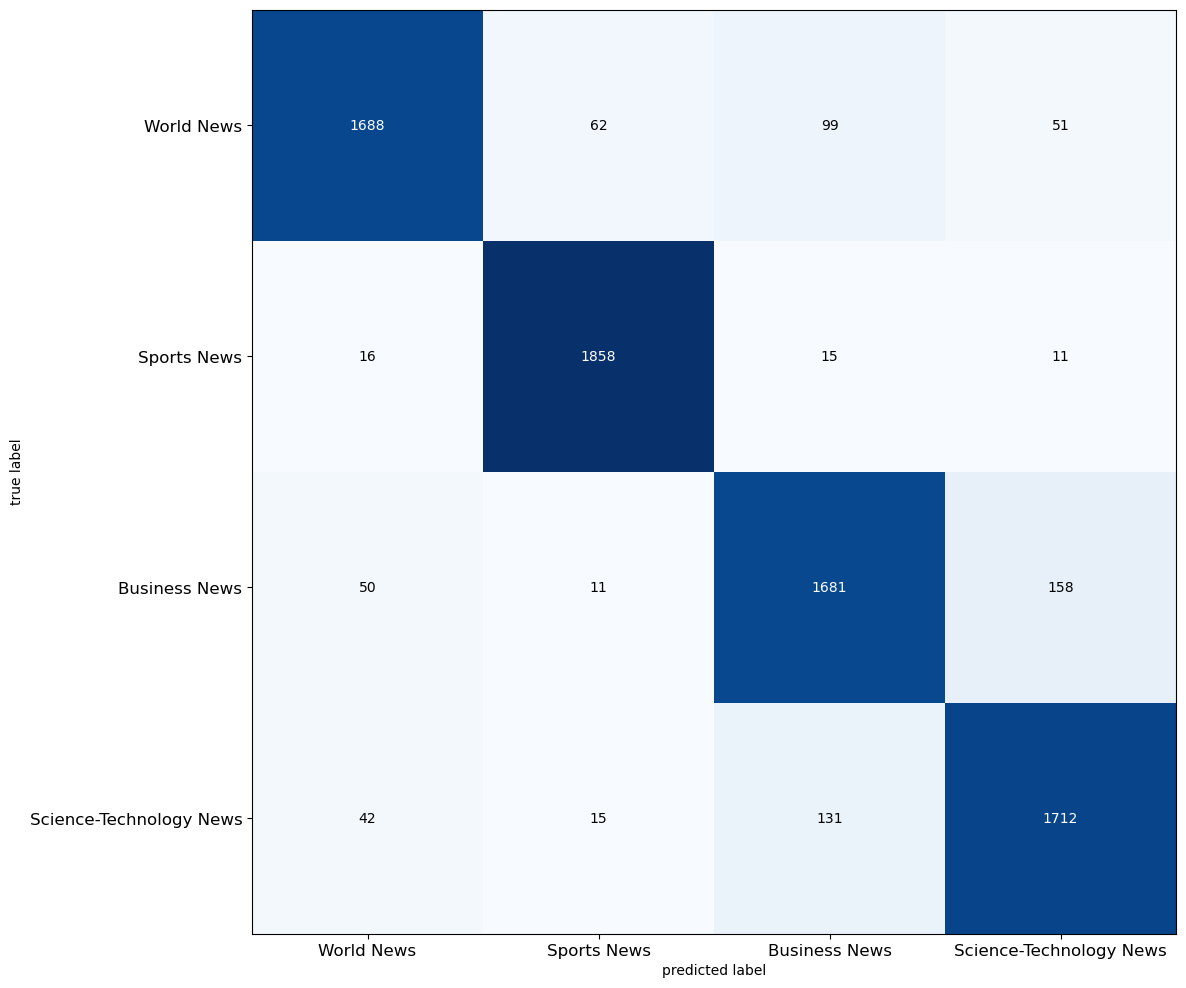

In [21]:
labels= ['World News', 'Sports News', 'Business News', 'Science-Technology News']
preds=[np.argmax(i) for i in model.predict(X_test)]
cm=confusion_matrix(y_test,preds)
plot_confusion_matrix(cm,figsize=(16,12),hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(4),labels,fontsize=12)
plt.yticks(range(4),labels,fontsize=12)
plt.show()

### Recall, Precision and Accuracy

In [22]:
print("Recall of the model is {:.2f}".format(recall_score(y_test, preds, average='micro')))
print("Precision of the model is {:.2f}".format(precision_score(y_test, preds, average='micro')))
print("Accuracy of the model is {:.2f}".format(accuracy_score(y_test, preds)))

Recall of the model is 0.91
Precision of the model is 0.91
Accuracy of the model is 0.91
